In [340]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


import sys
sys.path.append('../Utilities/')

from tqdm.notebook import tqdm

import importlib
import data_utils
importlib.reload(data_utils)

## Import MDS from sklearn
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score, f1_score
mds = MDS(n_components=1, random_state=0, normalized_stress='auto')

In [341]:
class UNet1D(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, num_layers=2):
        super(UNet1D, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.num_start_filters = 32

        self._create_unet(self.in_channels, self.num_start_filters)

        self.encoder_output_shape = int(np.floor(300/(2**depth)))
        self.encoder_feature_maps = int(self.num_start_filters * 2 ** (self.depth - 1))

        # self.bottleneck = self.create_linear_bottleneck((self.encoder_output_shape, self.encoder_feature_maps))
        self.bottleneck = nn.Sequential(
            nn.Conv1d(self.encoder_feature_maps, 2 * self.encoder_feature_maps, kernel_size=1, padding=0),
            nn.ReLU()
        )

        self.logits = nn.Conv1d(self.num_start_filters, self.out_channels, 1, 1)

    def create_linear_bottleneck(self, shape):
        in_channels = shape[1]
        out_channels = shape[1] * 2

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels * shape[0], out_channels* shape[0]),
            nn.ReLU())

    def _create_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU()
        )

    def _create_decoder_block(self, in_channels, out_channels):
        return nn.ModuleList([nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU()])

    def _create_unet(self, in_channels, out_channels):
        for _ in range(self.depth):
            self.encoder.append(self._create_encoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels*2

        out_channels = in_channels
        in_channels = in_channels * 2
        for _ in range(self.depth):
            self.decoder.append(self._create_decoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels//2

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x = enc(x)
            encoded.append(x)
            x = nn.MaxPool1d(kernel_size=2, stride=2)(x)
            
        x = self.bottleneck(x)  # Bottleneck layer
        # x = torch.reshape(x, (-1, self.encoder_feature_maps*2, self.encoder_output_shape))


        for dec in self.decoder:
            ## Adding input with encoder concatenation
            enc_output = encoded.pop()
            x = dec[0](x)
            ## Pad the decoder output to match the encoder output
            diff = enc_output.shape[2] - x.shape[2]
            x = F.pad(x, (diff // 2, diff - diff // 2))
            x = torch.cat((enc_output, x), dim=1)
            x = dec[1](x)
            x = dec[2](x)
        ## Add softmax to logits
        # x = self.softmax(x)

        return self.logits(x)

input_channels = 6 
output_channels = 1
depth = 3
num_layers = 2

model = UNet1D(input_channels, output_channels, depth, num_layers)
print(model)

UNet1D(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
    )
  )
  (decoder): ModuleList(
    (0): ModuleList(
      (0): ConvTranspose1d(256, 128, kernel_size=(2,), stride=(2,))
      (1): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): ReLU()
    )
    (1): ModuleList(
      (0): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
      (1): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): ReLU()
    )
    (2): ModuleList(
      (0): ConvTranspose1d(64, 32, kernel_size=(2,), stride=(2,))
      (1): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): ReLU()
    )
  )
  (bottleneck): Sequential(
    (0

In [342]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [343]:
# Generate synthetic data
num_superpixels = 300
num_features = 6
synthetic_data = np.random.rand(num_superpixels, num_features)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float32)

#Reshape
synthetic_data = synthetic_data.unsqueeze(0).transpose(1, 2)

# Pass the synthetic data through the U-Net model
with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating LightningModule 

In [402]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = dice_loss + BCE
        
        return Dice_BCE

In [405]:
class CloudSegmentationModel(pl.LightningModule):
    def __init__(self, depth=2):
        super(CloudSegmentationModel, self).__init__()
        self.unet = UNet1D(in_channels=6, out_channels=1, depth=depth)
        
    def forward(self, x):
        return nn.Sigmoid()(self.unet(x))

    def accuracy_score(self, y_true, y_pred):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return accuracy_score(y_true, y_pred)

    def training_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = DiceBCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = DiceBCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [406]:
model = CloudSegmentationModel()
print("Parameters: ",count_parameters(model))

with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Parameters:  91521
Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating Dataset

In [347]:
patches,mask = data_utils.get_patch(path_to_folders_images = "../Dataset/Natural_False_Color/", path_to_folders_labels = "../Dataset/Entire_scene_gts/")

c:\Users\GP65\anaconda3\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [349]:
X = []
y = []
raw = []
slic_map = []
original_ordering = []

for i,j in tqdm(list(zip(patches,mask))):
    # try:
    segmented_image_rgb, properties, labels, segmented_binary_array, segments = data_utils.convert_image_array_to_slic_with_properties(i,j,n_segments=300) 

    ## Getting the X and y arrays
    raw.append(segmented_image_rgb)
    slic_map.append(segments)
    X_array = np.array([list(list(i.values())[1]) + list(i.values())[2:-1] for i in properties])
    y_array = np.array(labels)

    ## Normalizing the X_array columwise
    X_array[:,0] = X_array[:,0]/255
    X_array[:,1] = X_array[:,1]/255
    X_array[:,2] = X_array[:,2]/255
    X_array[:,3] = X_array[:,3]/512
    X_array[:,4] = X_array[:,4]/512
    X_array[:,5] = X_array[:,5]/1000

    ## Ordering
    ordering = mds.fit_transform(X_array[:,3:5]).reshape(-1)
    original_ordering.append(ordering.argsort())
    X_array = X_array[ordering.argsort()]
    y_array = y_array[ordering.argsort()]


    ## Pad the X_array with -1 and y_array with 0 upto 300
    X_array = np.pad(X_array,((0,300-X_array.shape[0]),(0,0)),mode='constant',constant_values=-1)
    y_array = np.pad(y_array,(0,300-y_array.shape[0]),mode='constant',constant_values=0).reshape(-1,1)


    ## Appending
    X.append(X_array)
    y.append(y_array)
    
    # except KeyboardInterrupt:
    #     break
    # except:
    #     pass

  0%|          | 0/1472 [00:00<?, ?it/s]

In [350]:
def unpad_and_plot(X,y,original_ordering,slic_map):
    label = y[[X[:,0] != -1]]
    label = label[original_ordering.argsort()]
    plt.imshow(data_utils.reverse_segmentation(slic_map,label))
    plt.show()

In [358]:
# np.save('../Dataset/X.npy', np.array(X))
# np.save('../Dataset/Y.npy', np.array(y))
# np.save('../Dataset/raw.npy', np.array(raw))
# np.save('../Dataset/slic_map.npy', np.array(slic_map))
# np.save('../Dataset/original_ordering.npy', np.array(original_ordering))


X = np.load('../Dataset/X.npy')
y = np.load('../Dataset/Y.npy')
raw = np.load('../Dataset/raw.npy')
slic_map = np.load('../Dataset/slic_map.npy')
original_ordering = np.load('../Dataset/original_ordering.npy', allow_pickle=True)

In [360]:
# ##plot segmented_image_rgb
# plt.imshow(raw[16])
# plt.show()
# unpad_and_plot(X[16],y[16],original_ordering[16],slic_map[16])

In [361]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = torch.tensor(self.X[idx], dtype=torch.float32).T
        y_item = torch.tensor(self.y[idx], dtype=torch.float32).T
        return x_item, y_item

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [362]:
## Divide X and Y into train and test sets
test_index = np.random.choice(range(len(X)), size=200, replace=False)
train_index = [i for i in range(len(X)) if i not in test_index]

X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

In [363]:
train_loader = create_dataloader(X_train,y_train,batch_size=64,shuffle=True)
test_loader = create_dataloader(X_test,y_test,batch_size=64,shuffle=True)

## Training with PL

In [407]:
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [416]:
# Initialize the model and trainer
segmentationModel = CloudSegmentationModel(depth=3)

In [417]:
logger = TensorBoardLogger('lightning_logs/', name='sgd_tagger')

In [418]:
checkpoint_callback = ModelCheckpoint(
    dirpath = './/model_checkpt/',
    filename = 'best-checkpoint',
    save_top_k=1,
    verbose = True,
    monitor='val_loss',
    mode='min'
)

In [419]:
trainer = Trainer(
    logger = logger,
    gpus=1 if torch.cuda.is_available() else None,
    max_epochs=1000,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20), checkpoint_callback]
)

# Train the model using the trainer
trainer.fit(segmentationModel, train_loader, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | unet | UNet1D | 386 K 
--------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.548     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 30.89it/s, loss=1.12, v_num=4]

Epoch 0, global step 20: 'val_loss' reached 1.13568 (best 1.13568), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 40.81it/s, loss=1.09, v_num=4]

Epoch 1, global step 40: 'val_loss' reached 1.05876 (best 1.05876), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 2: 100%|██████████| 24/24 [00:00<00:00, 39.54it/s, loss=1.02, v_num=4]

Epoch 2, global step 60: 'val_loss' reached 1.03618 (best 1.03618), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 3: 100%|██████████| 24/24 [00:00<00:00, 43.83it/s, loss=1.02, v_num=4]

Epoch 3, global step 80: 'val_loss' reached 1.03560 (best 1.03560), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 4: 100%|██████████| 24/24 [00:00<00:00, 45.68it/s, loss=1.02, v_num=4]

Epoch 4, global step 100: 'val_loss' reached 1.03284 (best 1.03284), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 5: 100%|██████████| 24/24 [00:00<00:00, 45.23it/s, loss=1.01, v_num=4]

Epoch 5, global step 120: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 24/24 [00:00<00:00, 45.71it/s, loss=1.01, v_num=4]

Epoch 6, global step 140: 'val_loss' reached 1.02424 (best 1.02424), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 7: 100%|██████████| 24/24 [00:00<00:00, 42.55it/s, loss=1.01, v_num=4]

Epoch 7, global step 160: 'val_loss' reached 1.02136 (best 1.02136), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 8: 100%|██████████| 24/24 [00:00<00:00, 43.09it/s, loss=1, v_num=4]    

Epoch 8, global step 180: 'val_loss' reached 1.01645 (best 1.01645), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 9: 100%|██████████| 24/24 [00:00<00:00, 43.59it/s, loss=0.992, v_num=4]

Epoch 9, global step 200: 'val_loss' reached 1.00496 (best 1.00496), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 10: 100%|██████████| 24/24 [00:00<00:00, 45.32it/s, loss=0.991, v_num=4]

Epoch 10, global step 220: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 24/24 [00:00<00:00, 45.75it/s, loss=0.986, v_num=4]

Epoch 11, global step 240: 'val_loss' reached 0.99959 (best 0.99959), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 12: 100%|██████████| 24/24 [00:00<00:00, 46.88it/s, loss=0.977, v_num=4]

Epoch 12, global step 260: 'val_loss' reached 0.99103 (best 0.99103), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 13: 100%|██████████| 24/24 [00:00<00:00, 47.71it/s, loss=0.969, v_num=4]

Epoch 13, global step 280: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 24/24 [00:00<00:00, 46.07it/s, loss=0.969, v_num=4]

Epoch 14, global step 300: 'val_loss' reached 0.98406 (best 0.98406), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 15: 100%|██████████| 24/24 [00:00<00:00, 46.97it/s, loss=0.958, v_num=4]

Epoch 15, global step 320: 'val_loss' reached 0.97840 (best 0.97840), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 16: 100%|██████████| 24/24 [00:00<00:00, 44.04it/s, loss=0.951, v_num=4]

Epoch 16, global step 340: 'val_loss' reached 0.96719 (best 0.96719), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 17: 100%|██████████| 24/24 [00:00<00:00, 42.47it/s, loss=0.944, v_num=4]

Epoch 17, global step 360: 'val_loss' reached 0.96541 (best 0.96541), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 18: 100%|██████████| 24/24 [00:00<00:00, 46.78it/s, loss=0.938, v_num=4]

Epoch 18, global step 380: 'val_loss' reached 0.95928 (best 0.95928), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 19: 100%|██████████| 24/24 [00:00<00:00, 47.52it/s, loss=0.932, v_num=4]

Epoch 19, global step 400: 'val_loss' reached 0.95782 (best 0.95782), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 20: 100%|██████████| 24/24 [00:00<00:00, 48.78it/s, loss=0.93, v_num=4] 

Epoch 20, global step 420: 'val_loss' reached 0.95516 (best 0.95516), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 21: 100%|██████████| 24/24 [00:00<00:00, 44.86it/s, loss=0.93, v_num=4] 

Epoch 21, global step 440: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 24/24 [00:00<00:00, 46.36it/s, loss=0.928, v_num=4]

Epoch 22, global step 460: 'val_loss' reached 0.94860 (best 0.94860), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 23: 100%|██████████| 24/24 [00:00<00:00, 46.07it/s, loss=0.921, v_num=4]

Epoch 23, global step 480: 'val_loss' reached 0.94343 (best 0.94343), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 24: 100%|██████████| 24/24 [00:00<00:00, 49.18it/s, loss=0.918, v_num=4]

Epoch 24, global step 500: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 24/24 [00:00<00:00, 42.70it/s, loss=0.921, v_num=4]

Epoch 25, global step 520: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 24/24 [00:00<00:00, 44.61it/s, loss=0.922, v_num=4]

Epoch 26, global step 540: 'val_loss' reached 0.94332 (best 0.94332), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 27: 100%|██████████| 24/24 [00:00<00:00, 46.06it/s, loss=0.915, v_num=4]

Epoch 27, global step 560: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 24/24 [00:00<00:00, 47.95it/s, loss=0.914, v_num=4]

Epoch 28, global step 580: 'val_loss' reached 0.93814 (best 0.93814), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 46.92it/s, loss=0.912, v_num=4]

Epoch 29, global step 600: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 24/24 [00:00<00:00, 43.56it/s, loss=0.912, v_num=4]

Epoch 30, global step 620: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 24/24 [00:00<00:00, 47.60it/s, loss=0.914, v_num=4]

Epoch 31, global step 640: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 24/24 [00:00<00:00, 44.67it/s, loss=0.911, v_num=4]

Epoch 32, global step 660: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 45.84it/s, loss=0.912, v_num=4]

Epoch 33, global step 680: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 24/24 [00:00<00:00, 44.94it/s, loss=0.912, v_num=4]

Epoch 34, global step 700: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 24/24 [00:00<00:00, 43.90it/s, loss=0.911, v_num=4]

Epoch 35, global step 720: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 24/24 [00:00<00:00, 45.71it/s, loss=0.908, v_num=4]

Epoch 36, global step 740: 'val_loss' reached 0.93332 (best 0.93332), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 37: 100%|██████████| 24/24 [00:00<00:00, 45.03it/s, loss=0.908, v_num=4]

Epoch 37, global step 760: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 24/24 [00:00<00:00, 44.52it/s, loss=0.913, v_num=4]

Epoch 38, global step 780: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 24/24 [00:00<00:00, 45.54it/s, loss=0.907, v_num=4]

Epoch 39, global step 800: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 24/24 [00:00<00:00, 45.90it/s, loss=0.908, v_num=4]

Epoch 40, global step 820: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 24/24 [00:00<00:00, 44.68it/s, loss=0.907, v_num=4]

Epoch 41, global step 840: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 24/24 [00:00<00:00, 46.15it/s, loss=0.91, v_num=4] 

Epoch 42, global step 860: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 24/24 [00:00<00:00, 46.88it/s, loss=0.906, v_num=4]

Epoch 43, global step 880: 'val_loss' reached 0.93222 (best 0.93222), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 44: 100%|██████████| 24/24 [00:00<00:00, 45.45it/s, loss=0.905, v_num=4]

Epoch 44, global step 900: 'val_loss' reached 0.93134 (best 0.93134), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 45: 100%|██████████| 24/24 [00:00<00:00, 44.77it/s, loss=0.904, v_num=4]

Epoch 45, global step 920: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 24/24 [00:00<00:00, 47.62it/s, loss=0.905, v_num=4]

Epoch 46, global step 940: 'val_loss' reached 0.93032 (best 0.93032), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 47: 100%|██████████| 24/24 [00:00<00:00, 47.62it/s, loss=0.902, v_num=4]

Epoch 47, global step 960: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 24/24 [00:00<00:00, 43.80it/s, loss=0.904, v_num=4]

Epoch 48, global step 980: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 24/24 [00:00<00:00, 45.82it/s, loss=0.904, v_num=4]

Epoch 49, global step 1000: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 24/24 [00:00<00:00, 48.81it/s, loss=0.905, v_num=4]

Epoch 50, global step 1020: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 24/24 [00:00<00:00, 48.05it/s, loss=0.904, v_num=4]

Epoch 51, global step 1040: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 24/24 [00:00<00:00, 44.04it/s, loss=0.901, v_num=4]

Epoch 52, global step 1060: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 24/24 [00:00<00:00, 46.15it/s, loss=0.9, v_num=4]  

Epoch 53, global step 1080: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 24/24 [00:00<00:00, 44.44it/s, loss=0.901, v_num=4]

Epoch 54, global step 1100: 'val_loss' reached 0.92898 (best 0.92898), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 55: 100%|██████████| 24/24 [00:00<00:00, 46.15it/s, loss=0.906, v_num=4]

Epoch 55, global step 1120: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 24/24 [00:00<00:00, 46.74it/s, loss=0.904, v_num=4]

Epoch 56, global step 1140: 'val_loss' reached 0.92869 (best 0.92869), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 57: 100%|██████████| 24/24 [00:00<00:00, 47.34it/s, loss=0.9, v_num=4]  

Epoch 57, global step 1160: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 24/24 [00:00<00:00, 48.68it/s, loss=0.9, v_num=4]  

Epoch 58, global step 1180: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 24/24 [00:00<00:00, 46.99it/s, loss=0.901, v_num=4]

Epoch 59, global step 1200: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 24/24 [00:00<00:00, 46.07it/s, loss=0.899, v_num=4]

Epoch 60, global step 1220: 'val_loss' reached 0.92792 (best 0.92792), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 61: 100%|██████████| 24/24 [00:00<00:00, 42.56it/s, loss=0.903, v_num=4]

Epoch 61, global step 1240: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 24/24 [00:00<00:00, 47.60it/s, loss=0.901, v_num=4]

Epoch 62, global step 1260: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 24/24 [00:00<00:00, 46.06it/s, loss=0.898, v_num=4]

Epoch 63, global step 1280: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 24/24 [00:00<00:00, 43.01it/s, loss=0.897, v_num=4]

Epoch 64, global step 1300: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 24/24 [00:00<00:00, 46.33it/s, loss=0.899, v_num=4]

Epoch 65, global step 1320: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 24/24 [00:00<00:00, 46.12it/s, loss=0.898, v_num=4]

Epoch 66, global step 1340: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 24/24 [00:00<00:00, 46.02it/s, loss=0.898, v_num=4]

Epoch 67, global step 1360: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 24/24 [00:00<00:00, 45.73it/s, loss=0.899, v_num=4]

Epoch 68, global step 1380: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 24/24 [00:00<00:00, 47.47it/s, loss=0.897, v_num=4]

Epoch 69, global step 1400: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 24/24 [00:00<00:00, 44.86it/s, loss=0.9, v_num=4]  

Epoch 70, global step 1420: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 24/24 [00:00<00:00, 46.15it/s, loss=0.897, v_num=4]

Epoch 71, global step 1440: 'val_loss' reached 0.92731 (best 0.92731), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 72: 100%|██████████| 24/24 [00:00<00:00, 48.39it/s, loss=0.897, v_num=4]

Epoch 72, global step 1460: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 24/24 [00:00<00:00, 46.69it/s, loss=0.896, v_num=4]

Epoch 73, global step 1480: 'val_loss' reached 0.92593 (best 0.92593), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 74: 100%|██████████| 24/24 [00:00<00:00, 42.40it/s, loss=0.895, v_num=4]

Epoch 74, global step 1500: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 24/24 [00:00<00:00, 44.16it/s, loss=0.899, v_num=4]

Epoch 75, global step 1520: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 24/24 [00:00<00:00, 46.92it/s, loss=0.896, v_num=4]

Epoch 76, global step 1540: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 24/24 [00:00<00:00, 46.18it/s, loss=0.895, v_num=4]

Epoch 77, global step 1560: 'val_loss' reached 0.92587 (best 0.92587), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 78: 100%|██████████| 24/24 [00:00<00:00, 46.02it/s, loss=0.894, v_num=4]

Epoch 78, global step 1580: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 24/24 [00:00<00:00, 43.48it/s, loss=0.895, v_num=4]

Epoch 79, global step 1600: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 24/24 [00:00<00:00, 49.27it/s, loss=0.895, v_num=4]

Epoch 80, global step 1620: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 24/24 [00:00<00:00, 47.65it/s, loss=0.894, v_num=4]

Epoch 81, global step 1640: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 24/24 [00:00<00:00, 47.05it/s, loss=0.894, v_num=4]

Epoch 82, global step 1660: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 24/24 [00:00<00:00, 48.27it/s, loss=0.894, v_num=4]

Epoch 83, global step 1680: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 24/24 [00:00<00:00, 40.88it/s, loss=0.892, v_num=4]

Epoch 84, global step 1700: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 24/24 [00:00<00:00, 47.06it/s, loss=0.892, v_num=4]

Epoch 85, global step 1720: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 24/24 [00:00<00:00, 48.48it/s, loss=0.891, v_num=4]

Epoch 86, global step 1740: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 24/24 [00:00<00:00, 47.52it/s, loss=0.889, v_num=4]

Epoch 87, global step 1760: 'val_loss' reached 0.92542 (best 0.92542), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 88: 100%|██████████| 24/24 [00:00<00:00, 42.86it/s, loss=0.89, v_num=4] 

Epoch 88, global step 1780: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 24/24 [00:00<00:00, 43.56it/s, loss=0.891, v_num=4]

Epoch 89, global step 1800: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 24/24 [00:00<00:00, 47.35it/s, loss=0.892, v_num=4]

Epoch 90, global step 1820: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 24/24 [00:00<00:00, 46.24it/s, loss=0.891, v_num=4]

Epoch 91, global step 1840: 'val_loss' reached 0.92450 (best 0.92450), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 92: 100%|██████████| 24/24 [00:00<00:00, 45.98it/s, loss=0.888, v_num=4]

Epoch 92, global step 1860: 'val_loss' reached 0.92424 (best 0.92424), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 93: 100%|██████████| 24/24 [00:00<00:00, 43.17it/s, loss=0.886, v_num=4]

Epoch 93, global step 1880: 'val_loss' reached 0.92423 (best 0.92423), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 94: 100%|██████████| 24/24 [00:00<00:00, 47.47it/s, loss=0.887, v_num=4]

Epoch 94, global step 1900: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 24/24 [00:00<00:00, 49.09it/s, loss=0.889, v_num=4]

Epoch 95, global step 1920: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 24/24 [00:00<00:00, 46.38it/s, loss=0.889, v_num=4]

Epoch 96, global step 1940: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 24/24 [00:00<00:00, 43.53it/s, loss=0.888, v_num=4]

Epoch 97, global step 1960: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 24/24 [00:00<00:00, 46.55it/s, loss=0.888, v_num=4]

Epoch 98, global step 1980: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 24/24 [00:00<00:00, 45.86it/s, loss=0.887, v_num=4]

Epoch 99, global step 2000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 24/24 [00:00<00:00, 45.45it/s, loss=0.888, v_num=4]

Epoch 100, global step 2020: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 24/24 [00:00<00:00, 45.45it/s, loss=0.886, v_num=4]

Epoch 101, global step 2040: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 24/24 [00:00<00:00, 46.64it/s, loss=0.888, v_num=4]

Epoch 102, global step 2060: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 24/24 [00:00<00:00, 44.28it/s, loss=0.886, v_num=4]

Epoch 103, global step 2080: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 24/24 [00:00<00:00, 45.98it/s, loss=0.886, v_num=4]

Epoch 104, global step 2100: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 24/24 [00:00<00:00, 45.56it/s, loss=0.884, v_num=4]

Epoch 105, global step 2120: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 24/24 [00:00<00:00, 45.20it/s, loss=0.884, v_num=4]

Epoch 106, global step 2140: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 24/24 [00:00<00:00, 46.07it/s, loss=0.882, v_num=4]

Epoch 107, global step 2160: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 24/24 [00:00<00:00, 47.10it/s, loss=0.885, v_num=4]

Epoch 108, global step 2180: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 24/24 [00:00<00:00, 46.33it/s, loss=0.885, v_num=4]

Epoch 109, global step 2200: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 24/24 [00:00<00:00, 48.74it/s, loss=0.886, v_num=4]

Epoch 110, global step 2220: 'val_loss' reached 0.92383 (best 0.92383), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v4.ckpt' as top 1


Epoch 111: 100%|██████████| 24/24 [00:00<00:00, 45.41it/s, loss=0.881, v_num=4]

Epoch 111, global step 2240: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 24/24 [00:00<00:00, 45.80it/s, loss=0.881, v_num=4]

Epoch 112, global step 2260: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 24/24 [00:00<00:00, 44.82it/s, loss=0.88, v_num=4] 

Epoch 113, global step 2280: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 24/24 [00:00<00:00, 43.65it/s, loss=0.879, v_num=4]

Epoch 114, global step 2300: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 24/24 [00:00<00:00, 45.03it/s, loss=0.878, v_num=4]

Epoch 115, global step 2320: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 24/24 [00:00<00:00, 46.65it/s, loss=0.882, v_num=4]

Epoch 116, global step 2340: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 24/24 [00:00<00:00, 49.28it/s, loss=0.883, v_num=4]

Epoch 117, global step 2360: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 24/24 [00:00<00:00, 47.94it/s, loss=0.882, v_num=4]

Epoch 118, global step 2380: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 24/24 [00:00<00:00, 46.65it/s, loss=0.879, v_num=4]

Epoch 119, global step 2400: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 24/24 [00:00<00:00, 40.54it/s, loss=0.878, v_num=4]

Epoch 120, global step 2420: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 24/24 [00:00<00:00, 39.47it/s, loss=0.878, v_num=4]

Epoch 121, global step 2440: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 24/24 [00:00<00:00, 42.97it/s, loss=0.876, v_num=4]

Epoch 122, global step 2460: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 24/24 [00:00<00:00, 44.53it/s, loss=0.877, v_num=4]

Epoch 123, global step 2480: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 24/24 [00:00<00:00, 42.20it/s, loss=0.877, v_num=4]

Epoch 124, global step 2500: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 24/24 [00:00<00:00, 42.89it/s, loss=0.878, v_num=4]

Epoch 125, global step 2520: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 24/24 [00:00<00:00, 44.36it/s, loss=0.876, v_num=4]

Epoch 126, global step 2540: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 24/24 [00:00<00:00, 43.56it/s, loss=0.876, v_num=4]

Epoch 127, global step 2560: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 24/24 [00:00<00:00, 43.88it/s, loss=0.876, v_num=4]

Epoch 128, global step 2580: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 24/24 [00:00<00:00, 42.80it/s, loss=0.875, v_num=4]

Epoch 129, global step 2600: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 24/24 [00:00<00:00, 43.88it/s, loss=0.876, v_num=4]

Epoch 130, global step 2620: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 24/24 [00:00<00:00, 43.24it/s, loss=0.876, v_num=4]


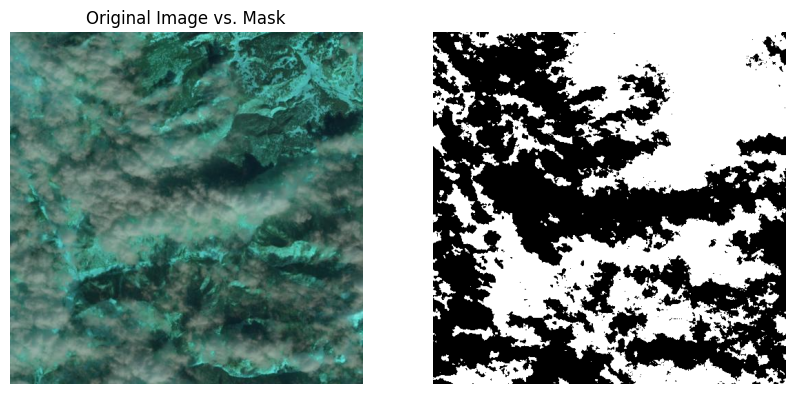

In [414]:
## Plot the mask and the image in a subplot
def plot_mask_and_image(image, mask, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[1].imshow(mask, cmap='gray')
    if title is not None:
        ax[0].set_title(title)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

i = 778
plot_mask_and_image(patches[i], mask[i], title="Original Image vs. Mask")

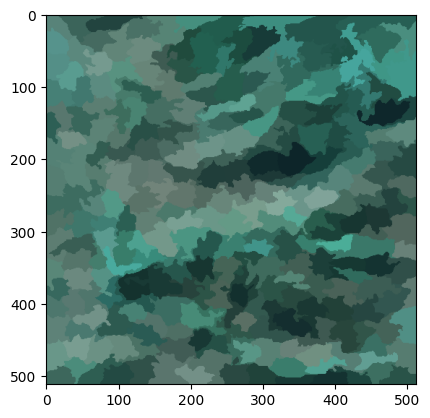

<ipython-input-350-776773d9e661>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  label = y[[X[:,0] != -1]]


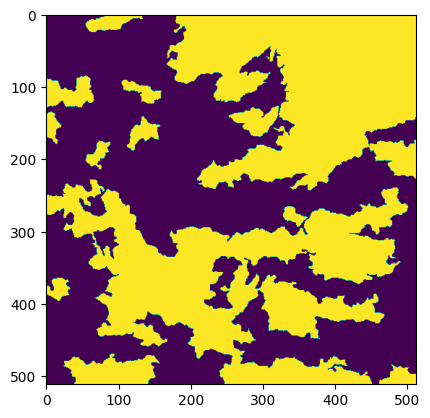

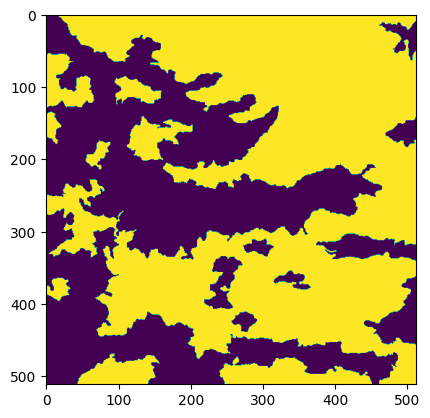

In [415]:
##plot segmented_image_rgb
i = 778
plt.imshow(raw[i])
plt.show()
unpad_and_plot(X[i],y[i],original_ordering[i],slic_map[i])

y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
unpad_and_plot(X[i],y_pred,original_ordering[i],slic_map[i])

# APPENDIX

## Training the module

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

segmentationModel = CloudSegmentationModel().to(device)

# train_loader = None # Train loader for our dataset
# test_loader = None # Test loader for our dataset

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(segmentationModel.parameters(), lr=0.001)

# Training loop
num_epochs = 100
segmentationModel.train() 

for epoch in tqdm(range(num_epochs)):
    running_loss = 0

    segmentationModel.train()
    for superpixel, label in train_loader:
        superpixel = superpixel.to(device)
        label = label.to(device)

        # Forward pass
        output = segmentationModel(superpixel)
        loss = criterion(output, label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        ## Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total


    # Print epoch statistics
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Evaluation
    segmentationModel.eval()
    test_loss = 0

    with torch.no_grad():
        for superpixel, label in test_loader:
            superpixel = superpixel.to(device)
            label = label.to(device)

            output = segmentationModel(superpixel)
            test_loss += criterion(output, label).item()

            ## Calculate accuracy
            predicted = torch.round(output)
            correct = (predicted == label).sum().item()
            total = label.size(0) * label.size(1) * label.size(2)
            accuracy = correct / total


    test_loss /= len(test_loader)
    ## Print loss and accuracy
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.6364, Accuracy: 0.6186
Test Loss: 0.5749, Accuracy: 0.6813
Epoch [2/100], Loss: 0.5424, Accuracy: 0.8075
Test Loss: 0.5319, Accuracy: 0.7332
Epoch [3/100], Loss: 0.5089, Accuracy: 0.7436
Test Loss: 0.5077, Accuracy: 0.7726
Epoch [4/100], Loss: 0.4980, Accuracy: 0.7191
Test Loss: 0.5190, Accuracy: 0.7041
Epoch [5/100], Loss: 0.4874, Accuracy: 0.7807
Test Loss: 0.5052, Accuracy: 0.7741
Epoch [6/100], Loss: 0.4865, Accuracy: 0.8059
Test Loss: 0.4932, Accuracy: 0.7659
Epoch [7/100], Loss: 0.4706, Accuracy: 0.7999
Test Loss: 0.4940, Accuracy: 0.6825
Epoch [8/100], Loss: 0.4623, Accuracy: 0.7862
Test Loss: 0.4570, Accuracy: 0.7324
Epoch [9/100], Loss: 0.4311, Accuracy: 0.7923
Test Loss: 0.4193, Accuracy: 0.8353
Epoch [10/100], Loss: 0.4135, Accuracy: 0.8057
Test Loss: 0.4009, Accuracy: 0.8276
Epoch [11/100], Loss: 0.3908, Accuracy: 0.8448
Test Loss: 0.3932, Accuracy: 0.8185
Epoch [12/100], Loss: 0.3822, Accuracy: 0.8141
Test Loss: 0.4353, Accuracy: 0.8000
Epoch [13/100